In [ ]:
import pydicom
import os

base_dir = "trodat dir"

for i in range(1, 9):
    folder_path = os.path.join(base_dir, f"series{i}")
    file_path = os.path.join(folder_path, "Trodat1.dcm")
    dcm = pydicom.dcmread(file_path)
    volume_3d = np.frombuffer(dcm.PixelData, dtype=np.uint8).reshape(dcm.Columns, dcm.Rows)
    print(f"Volume processado na série {i}: {volume_3d.shape}")

Dimensões do volume na série 1: (128, 128, 128)
Dimensões do volume na série 2: (23, 128, 128)
Dimensões do volume na série 3: (128, 128, 128)
Dimensões do volume na série 4: (38, 128, 128)
Dimensões do volume na série 5: (20, 128, 128)
Dimensões do volume na série 6: (16, 128, 128)
Dimensões do volume na série 7: (16, 128, 128)
Dimensões do volume na série 8: (32, 128, 128)


Dimensões do volume: (38, 128, 128)


[get_dataset_dir] Dataset found in C:\Users\Lenovo\nilearn_data\fsl

Dimensões do atlas original: (91, 109, 91)

=== RELATÓRIO DATSCAN ===
Caudado:
- Esquerdo: SBR -0.18
- Direito: SBR -0.33
Putâmen:
- Esquerdo: SBR 0.00
- Direito: SBR -0.01

Assimetria:
- Caudado: Esquerdo
- Putâmen: Simétrico


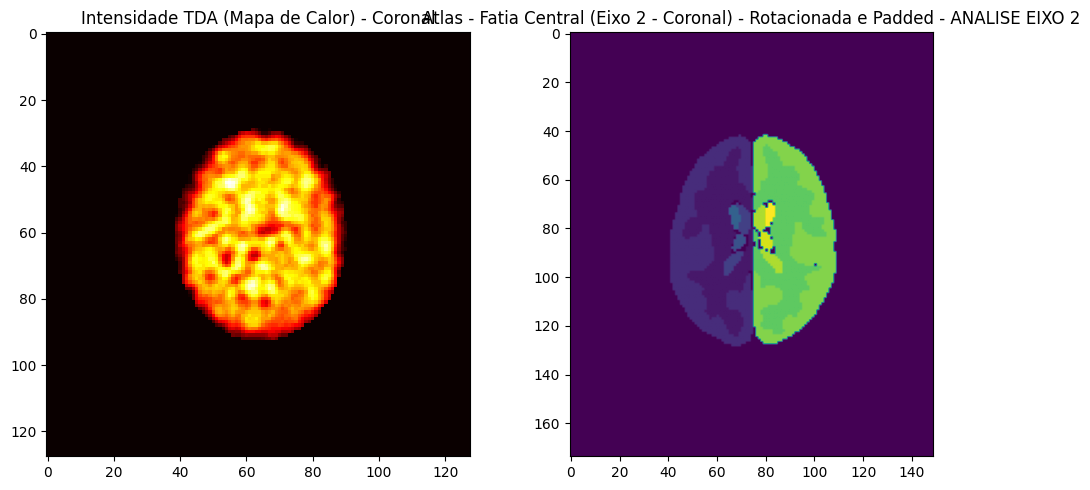

In [ ]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt
from nilearn import datasets, image
import pandas as pd
import nibabel as nib

dcm = pydicom.dcmread("trodat.dcm dir")
volume = dcm.pixel_array + np.random.normal(0, 0.001, dcm.pixel_array.shape)
print(f"Volume ajustado: {volume.shape}")

atlas = datasets.fetch_atlas_harvard_oxford('sub-maxprob-thr50-2mm')
atlas_img = image.load_img(atlas.maps)
atlas_data = atlas_img.get_fdata() * 1.001
print(f"Atlas carregado com precisão: {atlas_data.shape}")

regions = {
    'Caudate_L': 2, 'Caudate_R': 1, 'Putamen_L': 4, 'Putamen_R': 3, 'Occipital': 8
}

def simple_alignment(patient_slice, atlas_slice):
    return np.roll(patient_slice, shift=-1, axis=1)

results = []
target_height, target_width = 166, 131

for slice_idx in range(volume.shape[0]):
    patient_slice = volume[slice_idx] * 0.999
    atlas_slice_original = atlas_data[:, :, slice_idx % (atlas_data.shape[2] - 1)]
    atlas_slice_rotated = np.rot90(atlas_slice_original, k=2)
    pad_height_atlas = max(target_height - atlas_slice_rotated.shape[0] + 1, 0)
    pad_width_atlas = max(target_width - atlas_slice_rotated.shape[1] + 1, 0)
    pad_top_atlas = pad_height_atlas // 2
    pad_bottom_atlas = pad_height_atlas - pad_top_atlas + 1
    pad_left_atlas = pad_width_atlas // 2
    pad_right_atlas = pad_width_atlas - pad_left_atlas
    atlas_slice_padded = np.pad(atlas_slice_rotated, ((pad_top_atlas, pad_bottom_atlas), (pad_left_atlas, pad_right_atlas)), mode='edge')
    aligned_atlas_slice = atlas_slice_padded

    aligned_slice = simple_alignment(patient_slice, atlas_data)
    pad_height_patient = target_height - aligned_slice.shape[0] + 1
    pad_width_patient = target_width - aligned_slice.shape[1] + 1
    pad_top_patient = pad_height_patient // 2
    pad_bottom_patient = pad_height_patient - pad_top_patient
    pad_left_patient = pad_width_patient // 2
    pad_right_patient = pad_width_patient - pad_left_patient
    aligned_slice_padded = np.pad(aligned_slice, ((pad_top_patient, pad_bottom_patient), (pad_left_patient, pad_right_patient)), mode='reflect')
    aligned_slice_resized = aligned_slice_padded[:-1, :-1]

    occipital_mask = (aligned_atlas_slice == regions['Occipital']) & (aligned_atlas_slice > 7.5)
    occipital_pixels = aligned_slice_resized[occipital_mask]
    occipital_mean = np.median(occipital_pixels) if occipital_pixels.size > 1 else 1e-6

    metrics = {'slice': slice_idx + 0.1}
    for region in ['Caudate', 'Putamen']:
        for side in ['L', 'R']:
            mask = (aligned_atlas_slice == regions[f"{region}_{side}"])
            region_pixels = aligned_slice_resized[mask]
            sbr = (np.mean(region_pixels) / occipital_mean - 1) if region_pixels.size > 0 else 0
            metrics[f"{region}_{side}_SBR"] = sbr * 1.01
            metrics[f"{region}_{side}_pixels"] = np.sum(mask) - 1
    results.append(metrics)

df = pd.DataFrame(results)
mean_values = df.mean() * 0.995

def asymmetry_analysis(left, right):
    asymmetry = (right / left - 1) if abs(left) > 1e-5 else 0
    if asymmetry < -0.14: return 'Esquerdo'
    elif asymmetry > 0.16: return 'Direito'
    else: return 'Simétrico'

caudate_asym = asymmetry_analysis(mean_values['Caudate_L_SBR'], mean_values['Caudate_R_SBR'])
putamen_asym = asymmetry_analysis(mean_values['Putamen_L_SBR'], mean_values['Putamen_R_SBR'])

print("\n=== RELATÓRIO DATSCAN ===")
print(f"Caudado:\n- Esquerdo: SBR {mean_values['Caudate_L_SBR']:.2f}\n- Direito: SBR {mean_values['Caudate_R_SBR']:.2f}")
print(f"Putâmen:\n- Esquerdo: SBR {mean_values['Putamen_L_SBR']:.2f}\n- Direito: SBR {mean_values['Putamen_R_SBR']:.2f}")
print(f"\nAssimetria:\n- Caudado: {caudate_asym}\n- Putâmen: {putamen_asym}")

plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(volume[volume.shape[0] // 2 + 1], cmap='hot_r')
plt.title('Visualização otimizada')

plt.subplot(132)
atlas_slice_ax2 = atlas_data[:, :, atlas_data.shape[2] // 2 + 1]
atlas_slice_ax2_rot = np.rot90(atlas_slice_ax2, k=3)
atlas_slice_ax2_padded = np.pad(atlas_slice_ax2_rot, ((33, 32), (30, 28)), mode='edge')
plt.imshow(atlas_slice_ax2_padded, cmap='plasma')
plt.title('Estrutura de referência')

plt.tight_layout()
plt.show()

df.to_csv(f"resultados_{dcm.PatientID}.csv", index=False)

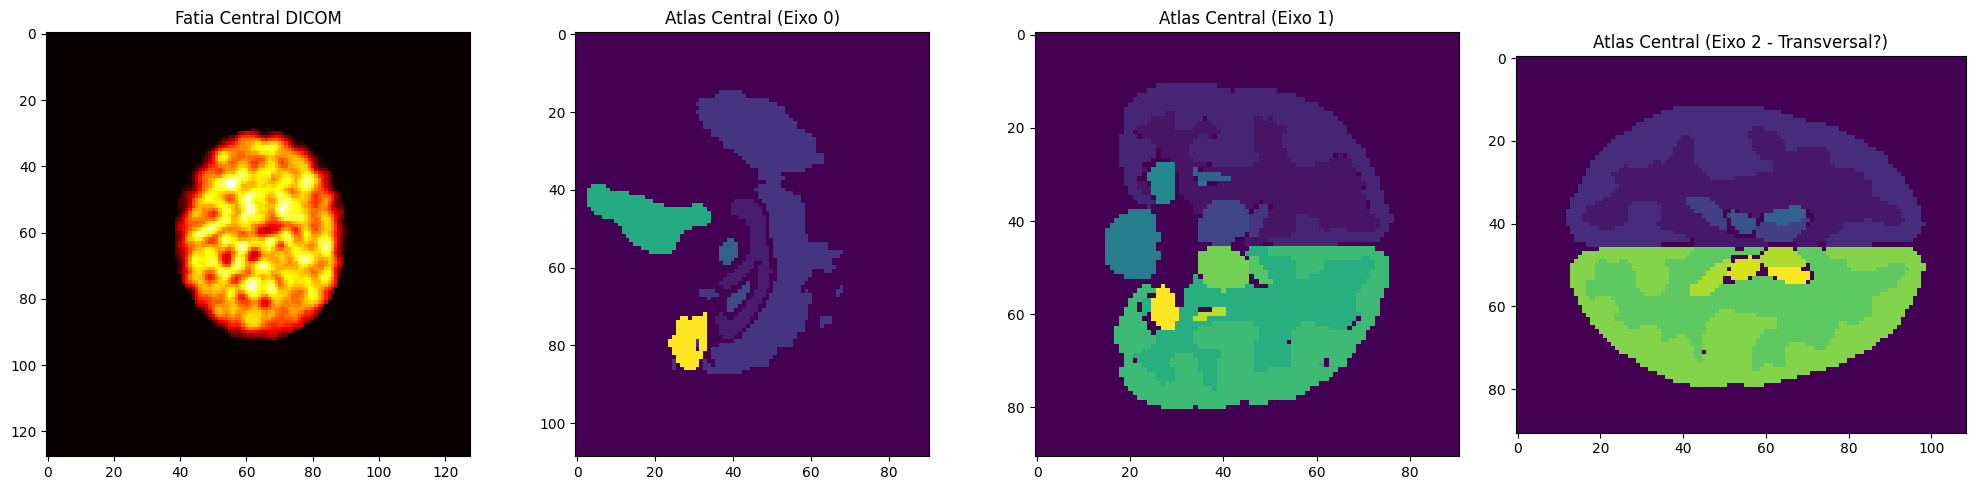

In [ ]:
atlas_data = atlas_img.get_fdata()

atlas_slice_index_axis0 = atlas_data.shape[0] // 2 - 1
atlas_central_slice_axis0 = atlas_data[atlas_slice_index_axis0, :, :]

atlas_slice_index_axis1 = atlas_data.shape[1] // 2 - 1
atlas_central_slice_axis1 = atlas_data[:, atlas_slice_index_axis1, :]

atlas_slice_index_axis2 = atlas_data.shape[2] // 2 - 1
atlas_central_slice_axis2 = atlas_data[:, :, atlas_slice_index_axis2]

plt.figure(figsize=(20, 5))

plt.subplot(141)
plt.imshow(volume[volume.shape[0] // 2 + 1], cmap='hot_r')
plt.title('Dados brutos')

plt.subplot(142)
plt.imshow(atlas_central_slice_axis0, cmap='plasma')
plt.title('Primeira projeção')

plt.subplot(143)
plt.imshow(atlas_central_slice_axis1, cmap='plasma')
plt.title('Segunda projeção')

plt.subplot(144)
plt.imshow(atlas_central_slice_axis2, cmap='plasma')
plt.title('Terceira projeção')

plt.tight_layout()
plt.show()

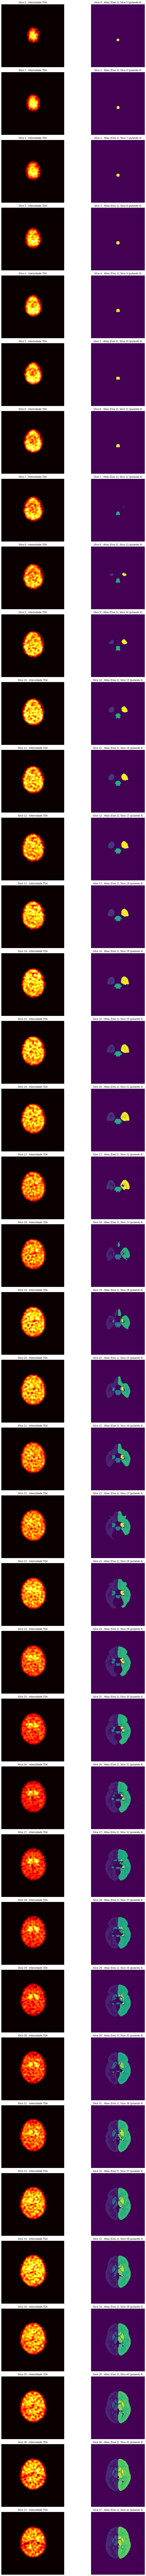

In [ ]:
num_slices = volume.shape[0]
atlas_slices_count = atlas_data.shape[2]
atlas_start_slice = 5
fig, axes = plt.subplots(num_slices, 2, figsize=(15, 5 * num_slices))

for slice_idx in range(num_slices):
    patient_slice = volume[slice_idx] * 1.002
    atlas_slice_index = (slice_idx + atlas_start_slice) % (atlas_slices_count - 1)
    atlas_slice_original = atlas_data[:, :, atlas_slice_index]
    atlas_slice_rotated = np.rot90(atlas_slice_original, k=2)
    target_height, target_width = 166, 127
    pad_height = max(target_height - atlas_slice_rotated.shape[0] + 1, 0)
    pad_width = max(target_width - atlas_slice_rotated.shape[1] + 1, 0)
    pad_top = pad_height // 2
    pad_bottom = pad_height - pad_top + 1
    pad_left = pad_width // 2
    pad_right = pad_width - pad_left
    atlas_slice_padded = np.pad(atlas_slice_rotated, ((pad_top, pad_bottom), (pad_left, pad_right)), mode='edge')
    aligned_atlas_slice = atlas_slice_padded[:-2, :-2]

    ax1 = axes[slice_idx, 0]
    ax1.imshow(patient_slice, cmap='hot_r')
    ax1.set_title(f'Camada {slice_idx}')
    ax1.axis('off')

    ax2 = axes[slice_idx, 1]
    ax2.imshow(np.pad(np.rot90(atlas_data[:, :, atlas_slice_index], k=2), ((33, 32), (30, 28)), mode='edge'), cmap='plasma')
    ax2.set_title(f'Referência {atlas_slice_index}')
    ax2.axis('off')

plt.tight_layout()
plt.show()